In [28]:
import numpy as np
import matplotlib.pyplot as plt

np.set_printoptions(precision=4, suppress=True)

(2, 500)

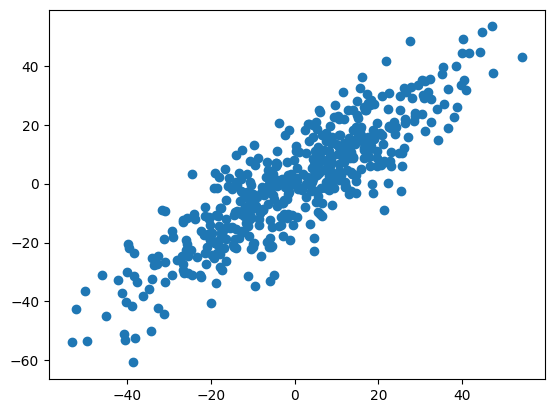

In [29]:
np.random.seed(0)

mean = [100, 150]  # center of data
cov = [[400, 350],
       [350, 400]]  # spread of data

X = np.random.multivariate_normal(mean, cov, size=500).T
X = X - X.mean(axis=1, keepdims=True)

X.shape
_ = plt.scatter(*X)

# Finding PCs using `C = XX'/n` approach

In [30]:
n = X.shape[1]
C = X @ X.T / n
C.shape

(2, 2)

In [31]:
eigenvalues, eigenvectors = np.linalg.eigh(C)
sorted_indices = np.argsort(eigenvalues)[::-1]
eigenvalues = eigenvalues[sorted_indices]
eigenvectors = eigenvectors[:, sorted_indices]

eigenvalues
eigenvectors

array([710.85  ,  49.9875])

array([[ 0.705 , -0.7092],
       [ 0.7092,  0.705 ]])

# Finding PCs using `K = X'X` approach

In [32]:
K = X.T @ X
K.shape

(500, 500)

In [33]:
n_lambdas, betas = np.linalg.eigh(K)
sorted_indices = np.argsort(n_lambdas)[::-1]
n_lambdas = n_lambdas[sorted_indices]
betas = betas[:, sorted_indices]

n_lambdas.shape
betas.shape

(500,)

(500, 500)

In [34]:
count_nonzero = min(X.shape)
n_lambdas = n_lambdas[:count_nonzero]
betas = betas[:, :count_nonzero]

n_lambdas.shape
betas.shape

(2,)

(500, 2)

In [35]:
alphas = betas / np.sqrt(n_lambdas).reshape(1, -1)
alphas.shape

(500, 2)

In [36]:
eigenvalues_ = n_lambdas / n
eigenvectors_ = X @ alphas

# using `C = XX'/n` approach
eigenvalues
eigenvectors

# using `K = X'X` approach
eigenvalues_
eigenvectors_

array([710.85  ,  49.9875])

array([[ 0.705 , -0.7092],
       [ 0.7092,  0.705 ]])

array([710.85  ,  49.9875])

array([[ 0.705 ,  0.7092],
       [ 0.7092, -0.705 ]])

# Rest is same for both approaches

In [37]:
np.cumsum(eigenvalues) / sum(eigenvalues)

array([0.9343, 1.    ])

In [38]:
k = 1
W = eigenvectors[:, :k]
W

array([[0.705 ],
       [0.7092]])

In [39]:
coefficients = X.T @ W
coefficients.shape

(500, 1)

In [40]:
X_ = (coefficients @ W.T).T
X_.shape

(2, 500)

In [41]:
np.sqrt(np.mean((X - X_)**2))  # rmse

np.float64(4.999374289343242)

### Plotting the reconstructed data

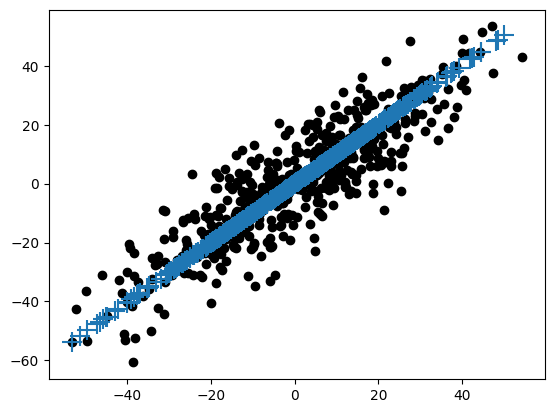

In [42]:
_ = plt.scatter(*X, color='k')
_ = plt.scatter(*X_, marker="+", s=200)

### Plotting only coefficients

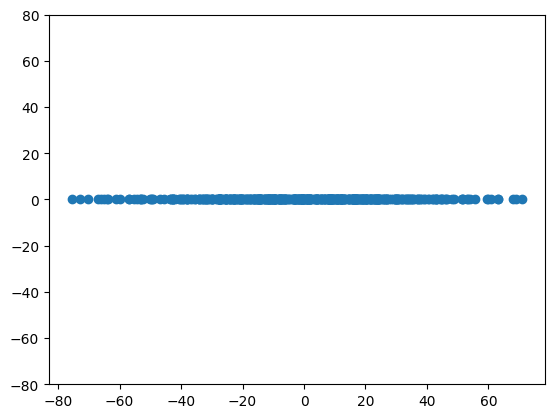

In [43]:
if k == 1:
  _ = plt.scatter(coefficients.T[0], [0]*n)

if k == 2:
  _ = plt.scatter(*coefficients.T)

_ = plt.ylim((-80, 80))

# Non linear relationships (Kernel PCA)

$$
K_{ij} = \exp\left(-\gamma \|x_i - x_j\|^2\right)
$$

$$
\|x_i - x_j\|^2 = \|x_i\|^2 + \|x_j\|^2 - 2x_i^\top x_j
$$

$$
\gamma = \frac{1}{2 \sigma^2}
$$


In [44]:
def rbf_kernel(X, gamma=1e-4):
  sq_dists = np.sum(X**2, axis=0, keepdims=True) + \
      np.sum(X**2, axis=0, keepdims=True).T - 2 * X.T @ X
  return np.exp(-gamma * sq_dists)

In [45]:
np.std(X, axis=1)
np.mean(np.std(X, axis=1))

array([19.4536, 19.5549])

np.float64(19.504260518248557)

In [46]:
sigma = np.mean(np.std(X, axis=1))
gamma = 1 / (2 * sigma**2)
gamma

np.float64(0.0013143499894001838)

### Kernel PCA with RBF kernel

In [87]:
K = rbf_kernel(X, gamma=1e-6)
K.shape

(500, 500)

In [88]:
# center the kernel matrix
n = K.shape[0]
one_n = np.ones((n, n)) / n

K = K - one_n @ K - K @ one_n + one_n @ K @ one_n
K.shape

(500, 500)

In [89]:
n_lambdas, betas = np.linalg.eigh(K)
sorted_indices = np.argsort(n_lambdas)[::-1]
n_lambdas = n_lambdas[sorted_indices]
betas = betas[:, sorted_indices]

n_lambdas.shape
betas.shape

(500,)

(500, 500)

In [90]:
(np.cumsum(n_lambdas) / sum(n_lambdas))[:20]
k = np.argmax(np.cumsum(n_lambdas) / sum(n_lambdas) >= 0.99) + 1
k

array([0.9323, 0.998 , 0.9999, 1.    , 1.    , 1.    , 1.    , 1.    ,
       1.    , 1.    , 1.    , 1.    , 1.    , 1.    , 1.    , 1.    ,
       1.    , 1.    , 1.    , 1.    ])

np.int64(2)

In [91]:
n_lambdas = n_lambdas[:k]
betas = betas[:, :k]

n_lambdas.shape
betas.shape

(2,)

(500, 2)

In [92]:
alphas = betas / np.sqrt(n_lambdas).reshape(1, -1)
alphas.shape

(500, 2)

In [93]:
coefficients = K @ alphas
coefficients.shape  # n * k

(500, 2)

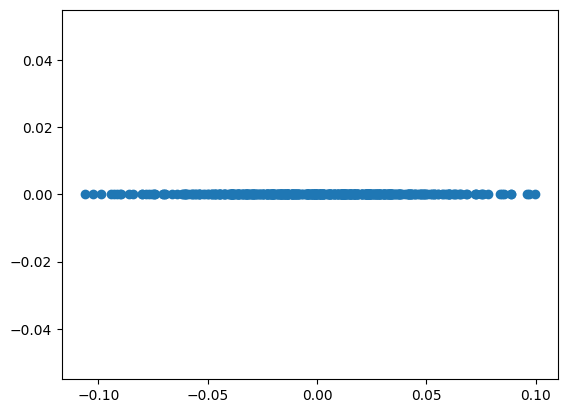

In [94]:
_ = plt.scatter(*coefficients.T[:1], [0]*n)  # plotting coefficients along top 1 PCs

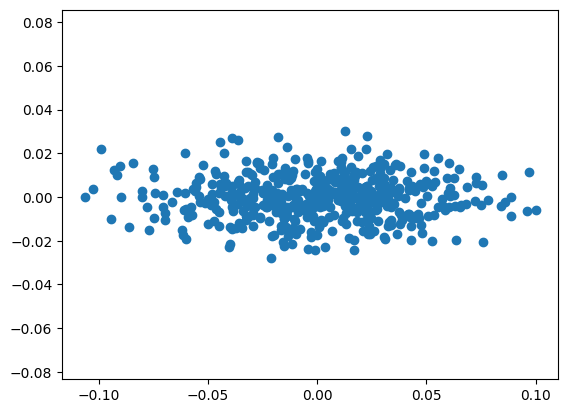

In [96]:
_ = plt.scatter(*coefficients.T[:2])  # plotting coefficients along top 2 PCs
_ = plt.axis("equal")